# Censored data
## Bayesian networks vs standard AFT models

We will examine data with censored values: for some observations we know the time that passed before the event, for others we know that event didn't ocurred before that time, but could have occurred later. 

The traditional way of doing analysis with such data is Survival Analysis: in particular we can use Kaplan Meier curves, the best non-parametric estimate of survival function.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns
import pymc3 as pm

from sklearn.linear_model import LinearRegression
from lifelines import KaplanMeierFitter, WeibullAFTFitter, LogNormalAFTFitter

In [2]:
data = pd.read_stata("data/seasick_eng_data.dta")
data.head()

,intens,time,vomit
0,1.0,30.0,1.0
1,1.0,50.0,1.0
2,1.0,50.0,0.0
3,1.0,51.0,1.0
4,1.0,66.0,0.0


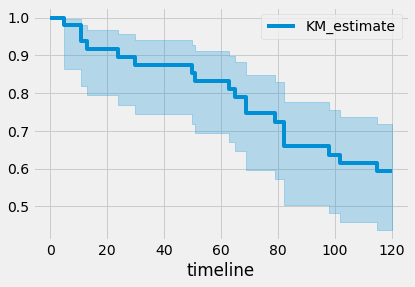

In [3]:
kmf = KaplanMeierFitter()
kmf.fit(data.time, data.vomit)
kmf.plot()

In [4]:
data = pd.read_csv("data/censored_dat.csv")
data.head()

,x,y
0,-1.085631,-3.005719
1,0.997345,4.000000
2,0.282978,2.567086
3,-1.506295,-4.518265
4,-0.578600,-0.260902


## Censored data with constant censoring threshold 

Now consider a case when we have some **observed variable** (like age) and the outcome $y$ which could be censored. In this case we will consider censoring all observations higher than $4$.

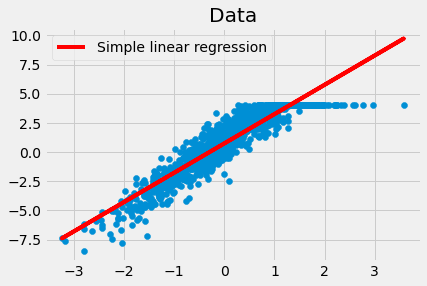

In [98]:
cens = pd.read_csv("data/censored_dat.csv")
x_obs = cens["x"].values
y_obs = cens["y"].values

ln = LinearRegression()
ln.fit(x_obs.reshape(-1, 1), y_obs)
y_pred = ln.predict(x_obs.reshape(-1, 1))

plt.scatter(x_obs, y_obs)
plt.plot(x_obs, y_pred, color="red", label="Simple linear regression")
plt.legend()
plt.title("Data");

We clearly see the bias in the data. Observations with $y$ higher than $4$ are censored and set to $4$ automatically. This could be for example a sensor that measures some value only to a certain point. Obviosuly if we know that such mechanism occurrs in our data there is no point in ignoring that. These observations could have been much larger than 4. One way to solve this problem would be to simply ignore these observations. That would probably work here (especially for simple linear regression), but it would be stupid for more general types of censoring. In the most extreme case, we could have a clinical trial with a group in which one patient died very quickly, but the rest of them lived so the are censored. If we threw away their observation we would be doing reasoning about quality of the drug based only on one patient who died right away. Alsoif the relationship wasn't linear but was some more complicated function where $y$ could be bigger than $4$ in multiple intervals, we wouldn't be able to reason about some intervals of $x$ after throwing away parts of the data.

## Bayesian model
Since we know that the mechanism of censoring occurs, and also know how, we can model that with random variables. The universal tool for that is a bayesian network in which we describe the process how data is generated, condition on observed data and then reason about unknown variables. In our case these unknown variables are the balues of $y$ for $y>4$ and coefficients of a linear regression (since we are using baesian model we say that coefficient are random variables as well and follow some prior distribution).

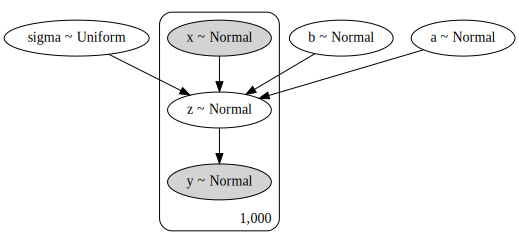

In [9]:
n_obs = x_obs.size
theta = 4
with pm.Model() as censored_linear_regression:
  a = pm.distributions.Normal("a", 1, sd=100)
  b = pm.distributions.Normal("b", 1, sd=100)
  # useless distribution (could be constant, because this is something we observe anyway)
  x = pm.distributions.Normal("x", 0, sd=1, 
                              shape=n_obs,
                              observed=x_obs)
  sigma = pm.distributions.Uniform("sigma", 0, 100)
  z = pm.distributions.Normal("z", a * x + b, sigma, shape=n_obs)
  y = pm.math.switch(z < theta, z, theta)
  # Just some random noise needed for a sampling to work
  y_ = pm.distributions.Normal("y", y, 1e-2, observed=y_obs)

pm.model_to_graphviz(censored_linear_regression)

In this model we have some initial data $x$ that we observe. Then this $x$, combined with the knowledge of parameters of linear regression (which we also model as random variables) tells us what is the value of $z$. But there is also the mechanism of censoring, so we don't observe $z$, but a truncated $y$ instead. 

Let's see how this works in practice and what are the estimated values.

In [10]:
with censored_linear_regression:
  sample = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [05:13<00:00, 31.94draws/s]


In [11]:
df_censored_regression = pm.summary(sample)
df_censored_regression.loc[["a", "b", "sigma"], :]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,2.987,0.038,2.918,3.060,0.0,0.0,8042.0,8034.0,8044.0,6472.0,1.0
b,1.018,0.033,0.956,1.081,0.0,0.0,9434.0,9434.0,9448.0,5880.0,1.0
sigma,0.959,0.023,0.917,1.005,0.0,0.0,8327.0,8317.0,8337.0,6063.0,1.0


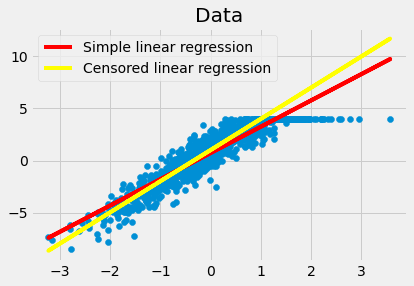

In [13]:
a_hat = df_censored_regression.loc["a", "mean"]
b_hat = df_censored_regression.loc["b", "mean"]
y_bayesian_pred = a_hat*x_obs + b_hat

plt.scatter(x_obs, y_obs)
plt.plot(x_obs, y_pred, color="red", label="Simple linear regression")
plt.plot(x_obs, y_bayesian_pred, color="yellow", label="Censored linear regression")
plt.legend()
plt.title("Data");

We see clear improvement - the line isn't skewed towards these censored outliers. BUT, it took 5 minutes to calculate all of these values and it was only simple regression (with censored data). Such procedures in R take a fraction of seconds (but the underlying models are a little bit different: either Cox model or parametric models with some assumption on the hazard function (or on distribution in other words). In the latter models we simply maximize likelihood of the censored data (the contribution of the single observation is the density for non-censored observation or survival function for censored observation). This is very fast to compute and without a need for sampling like in Bayesian or Monte Carlo methods. 

This is example how we pay for a generality of the framweork. With bayesian probabilistic modeling framework we simply specify the process of generation of data and let sampler do the rest. There is no need for writing custom functions, calculating likelihood or expectations, optimizing the model etc. One way to maybe speed up the computations, but without changing the probabilistic formulation of the model would be to change the way we calculate these samples. We could do it with EM Expectation Maximization, which requires calculating expected likelihood based on the conditional distribution of hidden variables and then iteratively change the parameters to maximize it. It takes some time to calculate all of this, but it would be interesting to see if it's worth it.

## Accelerated failure time model

Finally, let's try to fit a standard Accelerated Failure Time model. One issue is that the values of y are sometimes below y: this means that it can't be interpreted as time to survival (because time is never negative). To deal with it I exponeniated the $y$, fitted the model and then took logarithm of a prediction.

More details about the parametric censored regression and python lifelines package can be found here:
https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html.

In [48]:
observed_indicator = [0 if y == 4 else 1 for y in y_obs]
df = pd.DataFrame({"x": x_obs, "y": np.exp(y_obs), "observed": observed_indicator})
df.head()

,x,y,observed
0,-1.085631,0.049503,1
1,0.997345,54.598150,0
2,0.282978,13.027807,1
3,-1.506295,0.010908,1
4,-0.578600,0.770356,1


In [74]:
aft = LogNormalAFTFitter()
aft.fit(df, duration_col='y', event_col='observed')

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 162 right-censored observations>

In [78]:
y_aft_pred = aft.predict_expectation(df[["x"]]).values
y_aft_pred = np.log(y_aft_pred)

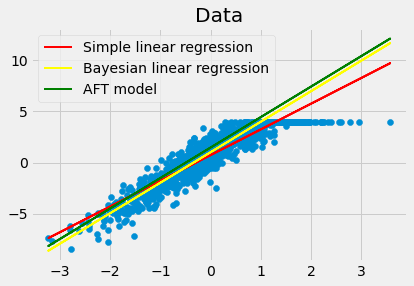

In [105]:
a_hat = df_censored_regression.loc["a", "mean"]
b_hat = df_censored_regression.loc["b", "mean"]
y_bayesian_pred = a_hat*x_obs + b_hat

plt.scatter(x_obs, y_obs)
plt.plot(x_obs, y_pred, color="red", linewidth=2, label="Simple linear regression")
plt.plot(x_obs, y_bayesian_pred, color="yellow", linewidth=2, label="Bayesian linear regression")
plt.plot(df[["x"]], y_aft_pred, color="green", linewidth=2, label="AFT model")
plt.legend()
plt.title("Data");
plt.show()

In [103]:
aft.print_summary()

It seems that both Bayesian linear regression and AFT model worked pretty much the same. (coefficients of $2.98$ and $1.02$). The question now would be how to do reasoning about the quality of the model, uncertainty and hypotheses testing. For AFT there are standard sets of procedures to diagnose the model and test hypotheses, for custom baeysian model I would have to think about how to do it.